C:\Users\hsham\AppData\Local\Temp\ipykernel_3084\784682687.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Best Parameters: {'model__max_depth': None, 'model__min_child_weight': 1, 'model__n_estimators': 100}
Validation Mean Squared Error: 3.2854070222593132
Validation Mean Absolute Error: 0.9743426573073872
Validation R² Score: 0.41477609081541844
Validation RMSE: 1.8125691772341581
Validation MAPE: 0.10451072056559117


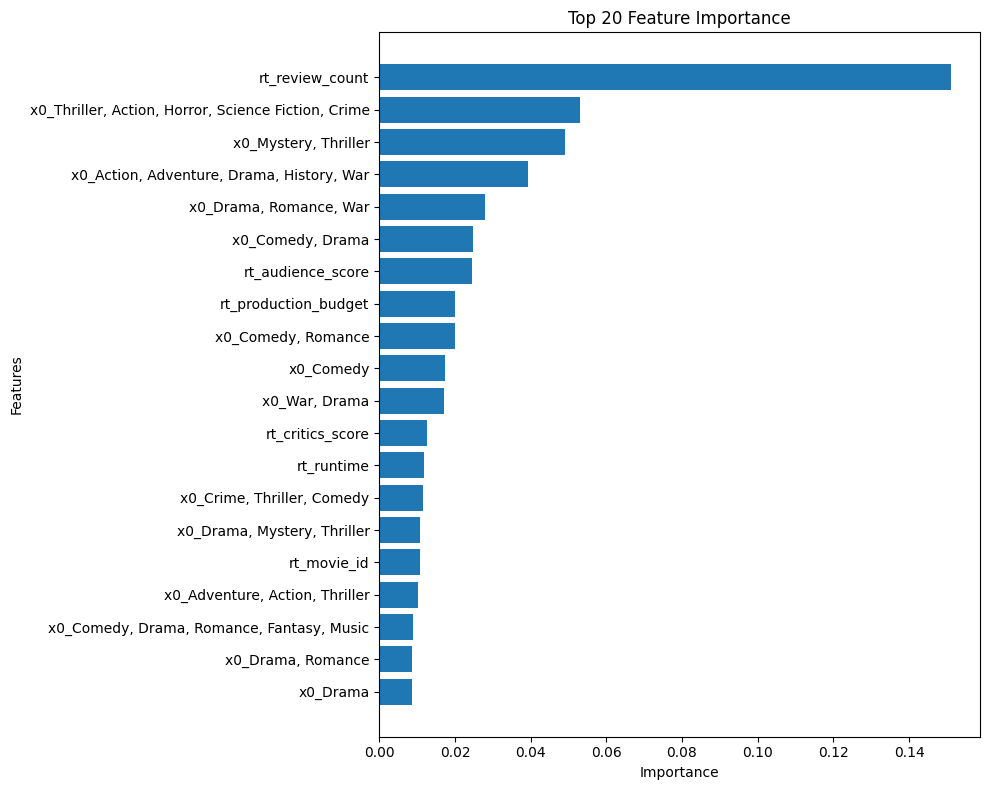

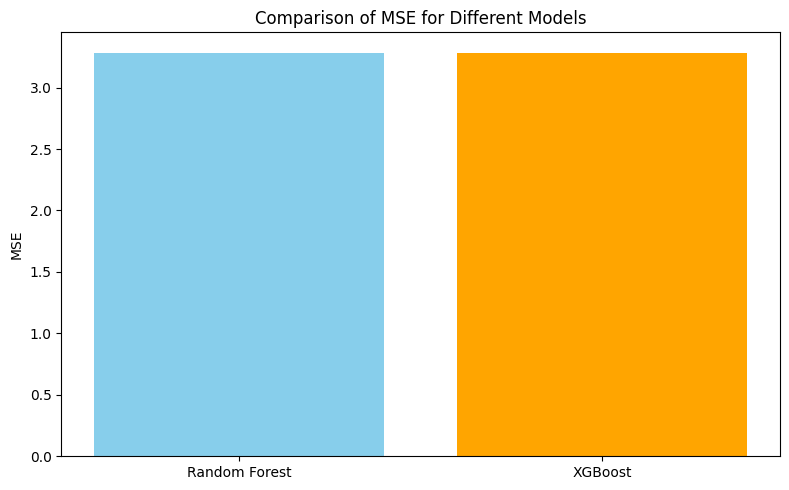

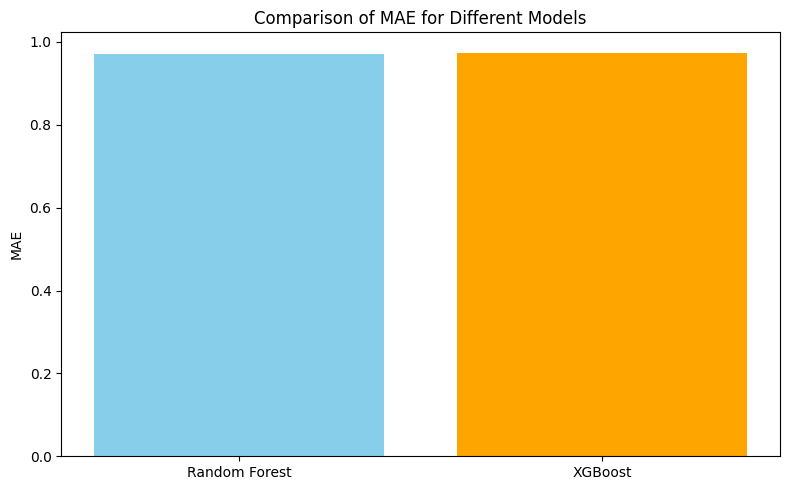

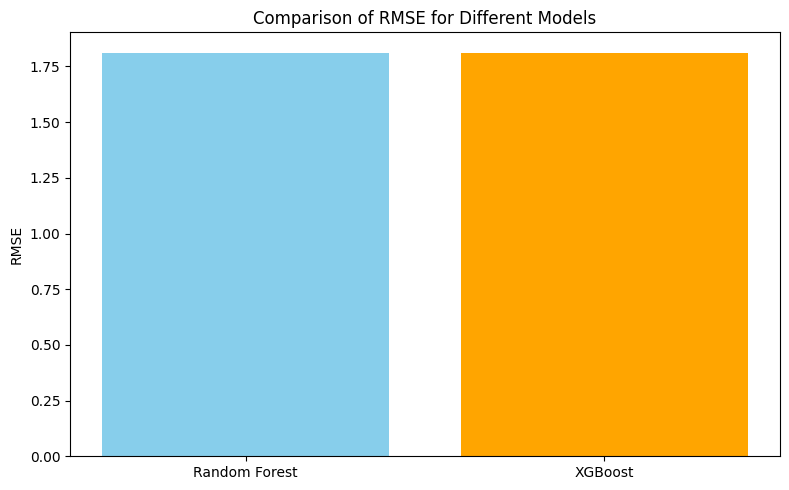

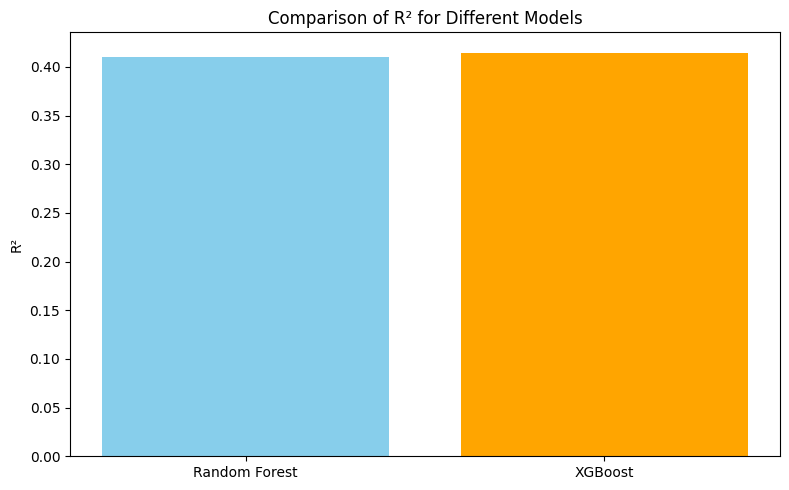

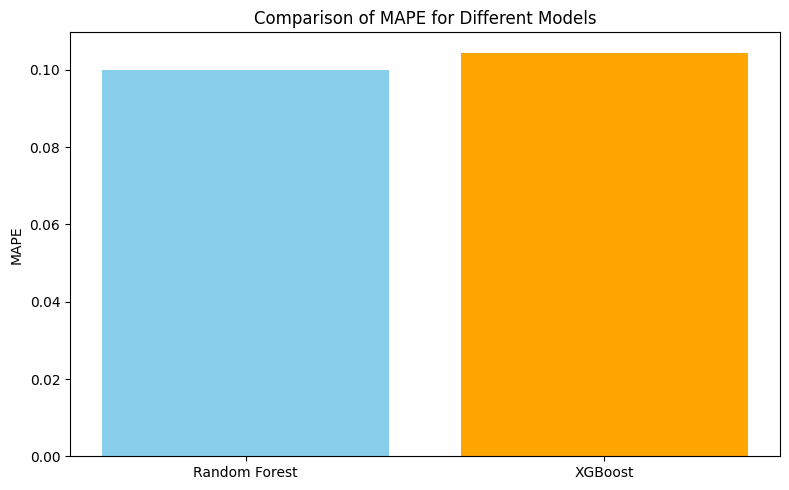

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import ast
from collections import Counter

df_movies = pd.read_csv(r"data/rotten_tomatoes_5000_movies.csv")
df_credit = pd.read_csv(r"data/rotten_tomatoes_5000_credits.csv")

# Merge df_movies and df_credit on 'rt_movie_id'
df = pd.merge(df_movies, df_credit, on='rt_movie_id', how='left')

# Remove rows where 'rt_box_office' is 0
df = df[df['rt_box_office'] != 0]

# Function to parse genres, actors, and directors safely
def parse_genres(genres_str):
    try:
        genres = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres]
    except:
        return []

def parse_actors(actors_str):
    try:
        actors = ast.literal_eval(actors_str)
        return [actor['name'] for actor in actors]
    except:
        return []

def parse_directors(staff_str):
    try:
        staff = ast.literal_eval(staff_str)
        directors = [staff_member['name'] for staff_member in staff if staff_member['job'] == 'Director']
        return directors
    except:
        return []

# Process the dataset
df = pd.merge(df_movies, df_credit, on='rt_movie_id', how='left')
df = df[df['rt_box_office'] != 0]  # Remove rows with zero box office

# Parse the 'rt_genres' and other relevant columns
df['parsed_genres'] = df['rt_genres'].apply(parse_genres)
df['parsed_actors'] = df['rt_actors'].apply(parse_actors)
df['parsed_directors'] = df['rt_staff'].apply(parse_directors)

# Top actors and directors based on dataset frequency
all_actors = [actor for actors_list in df['parsed_actors'] for actor in actors_list]
actor_counts = Counter(all_actors)
top_actors = [actor for actor, _ in actor_counts.most_common(30)]

all_directors = [director for directors_list in df['parsed_directors'] for director in directors_list]
director_counts = Counter(all_directors)
top_directors = [director for director, _ in director_counts.most_common(10)]

# Add binary features for famous actors and directors
df['has_famous_actor'] = df['parsed_actors'].apply(lambda x: any(actor in top_actors for actor in x))
df['has_famous_director'] = df['parsed_directors'].apply(lambda x: any(director in top_directors for director in x))

# Convert boolean columns to integers
df['has_famous_actor'] = df['has_famous_actor'].astype(int)
df['has_famous_director'] = df['has_famous_director'].astype(int)

# Handle Outliers by removing extreme box office values using IQR
q1 = df['rt_box_office'].quantile(0.25)
q3 = df['rt_box_office'].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr
df = df[(df['rt_box_office'] >= lower_limit) & (df['rt_box_office'] <= upper_limit)]

# Apply log transformation to box office revenue
df['log_rt_box_office'] = np.log1p(df['rt_box_office'])

# Define features (X) and target (y)
y = df['log_rt_box_office']
X = df.drop(columns=['rt_box_office', 'log_rt_box_office', 'rt_genres', 'rt_actors', 'rt_staff', 'parsed_genres', 'parsed_actors', 'parsed_directors'])

# Convert genres to a single string for OneHotEncoder
X['genres_combination'] = df['parsed_genres'].apply(lambda x: ', '.join(x))

# Preprocessing
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = ['genres_combination']  # Specify categorical columns explicitly

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_child_weight': [1, 3, 5]
}

# Use XGBRegressor for hyperparameter tuning
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

grid_search = GridSearchCV(xgb_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the best model on validation set
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
mape_val = mean_absolute_percentage_error(y_val, y_pred_val)

print(f"Validation Mean Squared Error: {mse_val}")
print(f"Validation Mean Absolute Error: {mae_val}")
print(f"Validation R² Score: {r2_val}")
print(f"Validation RMSE: {rmse_val}")
print(f"Validation MAPE: {mape_val}")

# Feature Importance Plot
def plot_feature_importances(importances, feature_names, n=20):
    sorted_idx = np.argsort(importances)[::-1][:n]
    plt.figure(figsize=(10, 8))
    plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
    plt.title(f'Top {n} Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

feature_names = numerical_cols.tolist() + list(best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out())
feature_importances = best_model.named_steps['model'].feature_importances_
plot_feature_importances(feature_importances, feature_names, n=20)

# Model Comparison
metrics = ['MSE', 'MAE', 'RMSE', 'R²', 'MAPE']
models = ['Random Forest', 'XGBoost']
results = {
    'Random Forest': [3.28, 0.97, 1.81, 0.41, 0.10],  # Replace with actual RF metrics
    'XGBoost': [mse_val, mae_val, rmse_val, r2_val, mape_val]
}
results_df = pd.DataFrame(results, index=metrics)

# Plot comparison for each metric
for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.bar(results_df.columns, results_df.loc[metric], color=['skyblue', 'orange'])
    plt.title(f'Comparison of {metric} for Different Models')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()
